# Cas Kaggle ApC

## Participants

Martí Armengod Villar, 1673911 

Joan Marc Samó Rojas, 1679937 

## Base de dades 
La nostra Base de dades que tracta sobre de dades de partides de escacs aqui tenim el enllaç a la web de Kaggle

https://www.kaggle.com/datasets/datasnaek/chess

Hem escollit aquesta base de dades per que hem vist que predint quin jugador guayara ens ajuda a entendre quin tipus de jugades son mes probables que ens donin la victoria o com d'important es la experencia del jugador o altra informació ue podem extreure.

## Objectius

El que volem ser capaços es predir quin jugador guanyara a partir de la seva llençada inicial.

## Pasos a seguir
0. Feina previa
  * Importar dades i recursos
  * Definir funcions utils 
  * Eliminar files duplicats
  * Separem en train i test
1. EDA (exploratory data analysis):
  * Atributs
    - Descripció dels atributs:
    - Informació sobre el nostre 'target'
  * Correlació
  * Balancejades
2. Preprocessing:
  * Detecció de Nans
  * Eliminar atributs innecesaris
  * Codificacions
  * Altres modificacions
  * Matriu de Correlació
    - Correlacions altes
    - Correlacions moderades
    - Altres
  * Gràfic de Dispersió
  * Normalització de les dades

3. Metric selection:
  * Metriques per valorar predicció
  * Metriques per valorar model

4. Model Selection:
 * Cerca d'hiperparametres
 * Escollim entre 4 models

5. Analisi final
  * Analitzem resultat predit
  * Ideas finals


## 0. Feina previa

### Importar dades i recursos
Abans de fer res, importem tota l'informació que necesitem: la base de dades de games.csv i les funcions que utilitzarem per tractar les dades.

In [139]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.svm import SVC
import time

In [140]:
# Importar dades del CSV i separar 
dades = pd.read_csv('games.csv')
dades.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


### Definir funcions utils
Aquí definim unes quantes funcions que ens seran utils en un futur

In [141]:
#Funcions Generiques que utilitzarem mes endavant 

#visualtizar curva roc multicategorica 
def plot_roc_curve_mc(y_true, y_pred_prob):
    classes = np.unique(y_true)
    
    plt.figure()

    for c in classes:
        y_true_c = y_true == c

        fpr, tpr, thresholds = roc_curve(y_true_c, y_pred_prob[:,c])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='ROC curve ' + str(c) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

#visualtizar curva pr multicategorica 
def plot_precision_recall_curve_mc(y_true, y_pred_prob):
    classes = np.unique(y_true)
    
    plt.figure()

    for c in classes:
        y_true_c = (y_true == c).astype(int)

        precision, recall, thresholds = precision_recall_curve(y_true_c, y_pred_prob[:,c])
        average_precision = auc(recall, precision)

        plt.plot(recall, precision, lw=2, label='Precision-Recall curve ' + str(c) + ' (area = %0.2f)' % average_precision)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

#Funció per eliminar atributs
def eliminar_atributs(df, columnes_a_eliminar):
    df_sense_atributs = df.drop(columns=columnes_a_eliminar, axis=1)
    return df_sense_atributs

#Funció per tractar els opening_eco
def encode_opening_eco(code):
    group = code[0]  # Extrae la letra (A, B, C...)
    subgroup = code[1:]  # Extrae los números (YY)
    # Convertir letra a un número (A=1, B=2, ..., Z=26)
    group_num = ord(group) - ord('A') + 1
    # Combinar el grupo y el subgrupo
    encoded_value = int(f"{group_num}{subgroup}")
    return encoded_value
#

### Eliminar Duplicats
També ens hem donat compte que tenim files identiques repetides multiples vegades aixi que avanç de res el que farem es eliminar les repeticons asegurant-nos de eliminar nomes les que son 100% iguals. Com a conseqüencia, hem d'eliminar les columnes de created_at i last_move_at, que reulten tenir res ultats lleugerament diferents, encara que les partides son completament identiques.

In [142]:
# Elimina files duplicades completament iguals
print(f"Dades Abans de treure duplicats: {dades.shape[0]} files")

dades = dades.drop(columns = ["created_at", "last_move_at"])
dades = dades.drop_duplicates()


print()
print(f"Train Després de treure duplicats: {dades.shape[0]} files")

Dades Abans de treure duplicats: 20058 files

Train Després de treure duplicats: 19113 files


### Separem en train i test
Finalment, ara que tenim la base de dades corregida i el recursos necessaris, anem a separar el conjunt de dades en train i test.

In [143]:
train_set, test_set = train_test_split(dades,random_state=42,test_size=0.2)
train_set.head(5)

,id,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
17712,Q5HSsAlS,True,66,resign,black,8+0,shmulke,1577,bendomo,1596,d4 d5 c4 e6 Nc3 Nf6 Nf3 c5 cxd5 Nxd5 Nxd5 Qxd5...,D41,Queen's Gambit Declined: Semi-Tarrasch | 5.cxd5,9
7693,MDQflvGw,True,96,draw,draw,10+0,bocadagod,1531,ujjaldidarsingh,1430,d4 c5 dxc5 Qa5+ c3 Qxc5 Nf3 Nf6 e3 e5 Nbd2 Be7...,A43,Benoni Defense: Benoni Gambit Accepted,3
8120,87EiAT1b,False,98,mate,black,20+3,joelitrox1234,1500,lichessfiend,1723,d4 c5 c3 cxd4 cxd4 Nf6 Nf3 g6 Bd2 Bg7 e3 O-O B...,A43,Old Benoni Defense,2
17203,UxmNSiyE,True,72,mate,black,20+5,fazouane,1365,lio83390,1442,b3 e5 Nf3 Nc6 d4 Qf6 e3 Bb4+ c3 Ba5 g3 d5 Ba3 ...,A01,Nimzo-Larsen Attack: Modern Variation,2
17827,p0btVtj4,True,28,resign,black,10+0,element4life,1328,danya068,1300,e4 e6 Nf3 d5 Nc3 f5 exf5 d4 Ne4 exf5 Neg5 Nh6 ...,C00,French Defense: Two Knights Variation,5


## 1. EDA (exploratory data analysis):

Una vegada em tingut el data set a les nostres mans hem estat analitzant quines caracteristiques i atributs tenim per poder veure quin son mes utils i necesaris i quins no.

##### Atributs
La nostre base de dades te 16 atributs (columnes)

Són dels tipus següents:
- **Binaris:** Rated
- **Categòric:** Id, Created_at, Last_move_at, Victory_status, Winner, Increment_code, White_id, Black_id, Moves, Opening_eco, Opening_name
- **Numèrics:** Turns, White_rating, Black_rating, Opening_ply

##### Descripció dels atributs:
- **Id:** Identificador de la partida.
- **Rated:** La partida es amistosa (sense puntuació associada) o competitiva (amb puntuació associada).
- **Turns:** Numero de torns que ha durat la partida.
- **Victory_status:** Com ha quedat l'estat de la partida (mate,resign,draw).
- **Winner:** Color guanyador (Será el nostre target).
- **Increment_code:** Temps base i increment per torn de temps en la partida (format base(min)+increment(seg)).
- **White_id:** Identificador del jugador que fara servir les fitxes blanques.
- **White_rating:** Puntuació que té el jugador que utilitza les blanques.
- **Black_id:** Identificador del jugador que fara servir les fitxes negres.
- **Black_rating:** Puntuació que té el jugador que utilitza les negres.
- **Moves:** Movimnets que es relalitzen durant la partida.
- **Opening_eco:** Codi del grup al que pertany l'apertura segons la Encyclopaedia of Chess Openings (format XYY, amb X una lletra i YY un digit de 2 xifres).
- **Opening_name:** Nom de l'apertura.
- **Opening_ply:** Numero de moviments per realitzar l'obertura.

##### Informació sobre el nostre 'target'

És l'atribut Winner que es del tipus Categoric ja que tenim tres possibles opcions, que serien White, Black o Draw (Empat).

També hem de comentar que la nostra base de dades no conté nans.


In [144]:
tipus_atributs = train_set.info()
print(tipus_atributs)

<class 'pandas.core.frame.DataFrame'>
Index: 15290 entries, 17712 to 16499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15290 non-null  object
 1   rated           15290 non-null  bool  
 2   turns           15290 non-null  int64 
 3   victory_status  15290 non-null  object
 4   winner          15290 non-null  object
 5   increment_code  15290 non-null  object
 6   white_id        15290 non-null  object
 7   white_rating    15290 non-null  int64 
 8   black_id        15290 non-null  object
 9   black_rating    15290 non-null  int64 
 10  moves           15290 non-null  object
 11  opening_eco     15290 non-null  object
 12  opening_name    15290 non-null  object
 13  opening_ply     15290 non-null  int64 
dtypes: bool(1), int64(4), object(9)
memory usage: 1.6+ MB
None


### Correlació
Hem pogut observat que tenim alguna correlació entre atributs,

- Els atributs de **opening_eco**, **opening_name** i **opening_ply** estan molt relacionats, ja que depenen del tipus de moviment inicial que realitzi sera un nom de obertura amb uns moviments definits. La correlació sera molt més alta entre el opening_name i el opening_ply ja que per cada tipus de obertura te un numero predefinit de moviments inicials ja que si fos diferent ja seria una altre obertura.

- Els atribut **victory_status** conte una classe directament relacionada el nostre target **winner**, que es l'empat. Aixó ho haurem de solucionar d'alguna manera, ja que llavors les nostres prediccions estan sobreinformades.

- La diferencia entre **white_rating** i **black_rating** sembla ser molt important per detectar al guanyador

In [145]:
#correlació diferencia de rating
wr_ww = train_set.loc[train_set["winner"] == "white"]["white_rating"]
wr_bw = train_set.loc[train_set["winner"] == "black"]["white_rating"]
br_ww = train_set.loc[train_set["winner"] == "white"]["black_rating"]
br_bw = train_set.loc[train_set["winner"] == "black"]["black_rating"]
mean_diff_ww = np.mean(wr_ww - br_ww)
mean_diff_bw = np.mean(br_bw - wr_bw)

print("De mitxa les blanques tenen una ventatja sobre les negres quan guanyen de: " + str(mean_diff_ww))
print("De mitxa les negres tenen una ventatja sobre les blanques quan guanyen de: " + str(mean_diff_bw))

De mitxa les blanques tenen una ventatja sobre les negres quan guanyen de: 95.5393287886733
De mitxa les negres tenen una ventatja sobre les blanques quan guanyen de: 88.2828748379663


### Balancejades
Observem els seguents desbalancetjos en les següents dades:
- Tenim un 84 % de partides competitives i un 16% de partides amistoses.
- Tenim un 56% de resign i un 32% de mate en estats de victoria
- Tenim un 50% de vegades en les que ha guanyat el jugador de les fitxes blanques i un 45% que ha guanyat el jugador amb les fitxes negres.

**Conclusió:** 

El desbalanceig en les etiquetes pot provocar un rendiment deficient en la classe minoritària, fent que el model prefereixi la classe majoritària i augmenti la taxa de falsos negatius. Això pot resultar en mètriques enganyoses.

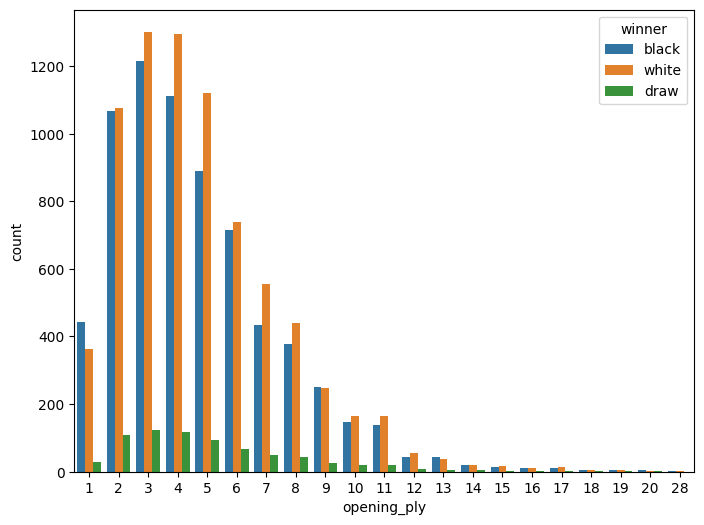

In [146]:
#graf de relació entre guanyador i jugades en el moviment inicial
sns.countplot(data=train_set, x='opening_ply', hue='winner')
plt.show()

## 2. Preprocessing:
Ara un cop que ja hem observat les dades amb les que tenim que tractar começarem mirant Si tenim nans, analitzant si s'han de normalitzar atributs, i decidint amb quins atributs ens hauriem de quedar.

### Detecció de Nans
Hem volgut assegurar-nos de si les nostres dades tenien o no Nans i tal i com haviem observat en la web del Kaggle no en tenim. Ho podem observar en la següent funcio de comprovacio de Nans, Cap columna te cap Nan.

In [147]:
nans = dades.isna().sum()
print(nans)

id                0
rated             0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64


### Eliminar atributs innecesaris
Hem de tenir en compte que tenim columnes com per exemple la id de la partida que no ens aporta cap dada rellevant ja que es unica per cada partida i no podriem obtenir informació d'ella.

Ara el farem es veure quines columnes són les que necesitem per poder predir el que volem saber que és qui guanyara segons els primers moviments.
- **Id**: Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que es el identificador de partida.
- **White_id**:  Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que és l'identificador del jugador que fara servir les fitxes blanques.
- **Black_id**: Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que és l'identificador del jugador que fara servir les fitxes negres.   
- **Victory_status:** Pel fet de contenir la classe draw, aquest atribut contamina els nostres resultats.
- **Move**: Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que són tots els movimnets que es relalitzen durant la partida i són practicament unics.
- **Opening_name**: Aquest atribut es considera no rellevant per a la predicció de quin color guanyara ja que són els noms de les jugades inicials.

In [148]:
train_set = eliminar_atributs(train_set,["id","white_id","black_id","white_id", "victory_status","moves","opening_name"])
test_set = eliminar_atributs(test_set,["id","white_id","black_id","white_id", "victory_status","moves","opening_name"])

print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15290 entries, 17712 to 16499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rated           15290 non-null  bool  
 1   turns           15290 non-null  int64 
 2   winner          15290 non-null  object
 3   increment_code  15290 non-null  object
 4   white_rating    15290 non-null  int64 
 5   black_rating    15290 non-null  int64 
 6   opening_eco     15290 non-null  object
 7   opening_ply     15290 non-null  int64 
dtypes: bool(1), int64(4), object(3)
memory usage: 970.6+ KB
None


### Codificacions
Anem a transformar en dades numeriques els atributs que no ho son. També crearem un encoding per les dades de rating bassats en el fet que a partir de cert nivells s'ha de considerar certs niveells més rellevants.

- **Increment_code**
    - **Tipus de Codificació**: Label Encoding
    - Aqui l'unic que farem és retallar la part final del numero que esta darrera de + ja que compte els temps extres que no ens interesa.
- **White_rating**
    - **Tipus de Codificació**: Label Encoding
    - Podem resumir els punts en 6 categories que dependra del valor de puntuació  apartir de 1100 anirem pujant la categoria creant del 1 al 6 per tal de saber el nivell del jugador.
- **Black_rating**
    - **Tipus de Codificació**: Label Encoding
    - Podem resumir els punts en 6 categories que dependra del valor de puntuació  apartir de 1100 anirem pujant la categoria creant del 1 al 6 per tal de saber el nivell del jugador.
- **Opening_eco**
    - **Tipus de Codificació**: Label Encoding
    - Podem crear una simple codificació transformant a dada numerica el unic caracter de la codificació (per exemple, B23 a 223).

In [149]:
train_set['increment_code'] = train_set['increment_code'].str.split('+').str[0].astype(int)
test_set['increment_code'] = test_set['increment_code'].str.split('+').str[0].astype(int)

#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Definir intervals i etiquetes
bins = [0, 1100, 1600, 2000, 2300, 3000, float('inf')]
labels = [1, 2, 3, 4, 5, 6]

# Aplicar a 'white_rating' i 'black_rating'
train_set['white_level'] = pd.cut(train_set['white_rating'], bins=bins, labels=labels, right=False).astype(int)
train_set['black_level'] = pd.cut(train_set['black_rating'], bins=bins, labels=labels, right=False).astype(int)

test_set['white_level'] = pd.cut(test_set['white_rating'], bins=bins, labels=labels, right=False).astype(int)
test_set['black_level'] = pd.cut(test_set['black_rating'], bins=bins, labels=labels, right=False).astype(int)

# Verificar distribucions
print(train_set['white_level'].value_counts())
print(train_set['black_level'].value_counts())

#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Crear un LabelEncoder
label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna 'winner'
train_set['winner'] = label_encoder.fit_transform(train_set['winner'])

# Veure el mapping de valors
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Per fer el mateix amb el conjunt de test:
test_set['winner'] = label_encoder.transform(test_set['winner'])

#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Aplicar label encoding a la cimuna opening_eco
train_set['opening_eco'] = train_set['opening_eco'].apply(encode_opening_eco)
test_set['opening_eco'] = test_set['opening_eco'].apply(encode_opening_eco)

#---------------------------------------------------------------------------------------------------------------------------------------------------------

train_set.head(5)

white_level
2    7745
3    5647
4    1220
1     510
5     168
Name: count, dtype: int64
black_level
2    7781
3    5552
4    1240
1     576
5     141
Name: count, dtype: int64
{'black': np.int64(0), 'draw': np.int64(1), 'white': np.int64(2)}


,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply,white_level,black_level
17712,True,66,0,8,1577,1596,441,9,2,2
7693,True,96,1,10,1531,1430,143,3,2,2
8120,False,98,0,20,1500,1723,143,2,2,3
17203,True,72,0,20,1365,1442,101,2,2,2
17827,True,28,0,10,1328,1300,300,5,2,2


### Altres modificacions
Construirem les columnes **diff_rating** i **diff_level**, així reduïrem el nombre de columnes pero es mantindrà l'informació que creïem necessaria, que es la differencia que hi ha d'un jugador repecte l'altre.

In [150]:
train_set["diff_rating"] = train_set["white_rating"] - train_set["black_rating"]
train_set["diff_level"] = train_set["white_level"] - train_set["black_level"]
train_set = eliminar_atributs(train_set,[ "white_rating", "black_rating", "white_level", "black_level"])

test_set["diff_rating"] = test_set["white_rating"] - test_set["black_rating"]
test_set["diff_level"] = test_set["white_level"] - test_set["black_level"]
test_set = eliminar_atributs(test_set,["white_rating", "black_rating", "white_level", "black_level"])

train_set.head(5)

,rated,turns,winner,increment_code,opening_eco,opening_ply,diff_rating,diff_level
17712,True,66,0,8,441,9,-19,0
7693,True,96,1,10,143,3,101,0
8120,False,98,0,20,143,2,-223,-1
17203,True,72,0,20,101,2,-77,0
17827,True,28,0,10,300,5,28,0


#### Matriu de Correlació

1. **Correlacions altes**:
   - Es pot observar clarament que un **diff_rating** i **diff_level** es correlacionen positivament amb el valor de **winner**. Aixó es degut a que contra més alt siguin aquells atributs, més ventatja a nivell de valoració tenen les blanques(2), que és un valor més alt que el de les negres(0). 
   - Una altra correlació interessant és entre **opening_eco** i **opening_ply**, que reflecteix la relació entre el tipus d'obertura i el nombre de moviments involucrats, cosa que té sentit en el context d'estratègies d'escacs.

2. **Correlacions moderades**:
   - Hi ha una correlació entre un valor de **turn** més alt i un **winner** més baix. Aixó es pot doar al fet conegut de que les blanques als escacs tenen una ventatja inicial moderad qu va reduïnt-se a mesura que avança la partida, per tants més torn sol donar una millor oportunitat a les negres per guanyar.

3. **Altres**:
   - Aquesta matriu no només ens mostra patrons evidents, sinó també llocs on la correlació no és tan forta com per exemple, entre rated i altres variables, que ens pot indicar que el fet de ser una partida classificada o no classificada té menys influència en els resultats.

<Axes: >

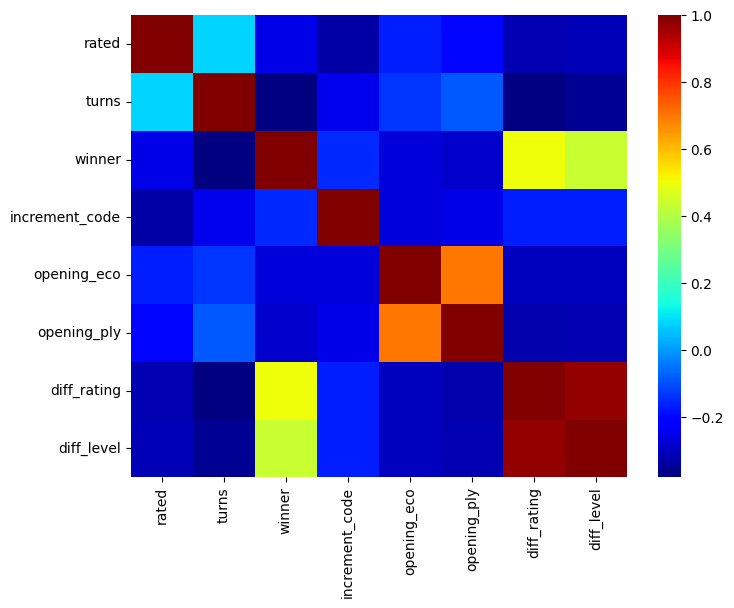

In [151]:
corr = train_set.corr(numeric_only=True) # take only numeric columns 
sns.heatmap(corr.corr(), annot=False, cmap='jet') # heatmap with numerical columns

#### Gràfic de Dispersió

A la següent grafica es mostra la disperció de **truns** repecte el **diff_rating**. Aixó mostra el fet evident de que una differencia de nivell molt llunyana a 0 indica una differencia molt gran de nivells entre jugadors i per tant una resolució de la partida més rapida.

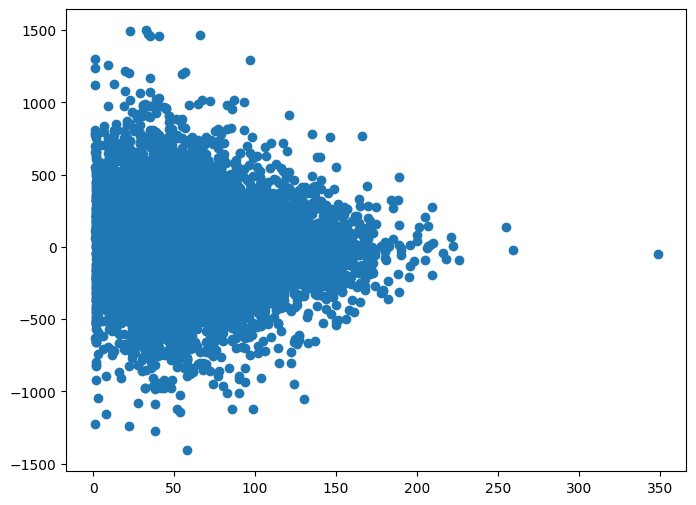

In [152]:
turns= train_set["turns"]
diff_rating=  train_set["diff_rating"]

plt.scatter(turns,diff_rating) 
plt.rcParams["figure.figsize"] = (8,6)

## Normalització de les dades
Normalitzem les dades amb StandardScaler()

Com podem veure. el grafic anterior esta en una mateixa escala.

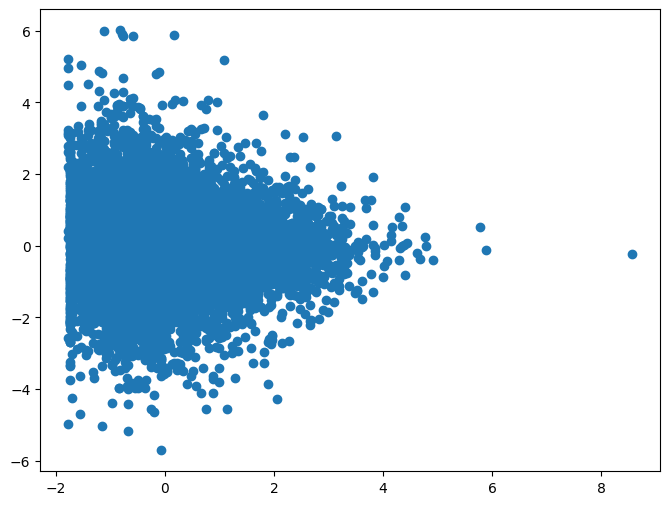

In [153]:
y_train = train_set['winner']
X_train = train_set.drop(columns=['winner'])
y_test = test_set['winner']
X_test = test_set.drop(columns=['winner'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

turns= X_train[:, train_set.columns.get_loc("turns")]
diff_rating=  X_train[: ,train_set.columns.get_loc("diff_rating") - 1]

plt.scatter(turns,diff_rating) 
plt.rcParams["figure.figsize"] = (8,6)

## 3. Metric selection:

Les millors metriques en aquest cas son les següents:

- Precission: volem saber si una apertura guanyadora ho es amb certessa, no ens interessa tenir un gran nombre d'opcions igulment valides sinó tenir clar quines ho són realment.

- Accuracy: per tenir una metica estandard amb la que traballar.

També farem us de les corves ROC i PR per mostrar visualment com de bones son les prediccions.


També en aquesta secció es mostra la funció per validar el model amb Cross Validation

In [154]:
def evaluate_prediction(y_test, y_pred_prob):
    #transformem probabilitat en certesa
    y_pred = np.argmax(y_pred_prob, axis=1)

    #Mostrem matriu de confusio
    print(confusion_matrix(y_test, y_pred))
    
    #Mostrem dades generals
    print(classification_report(y_test, y_pred))

    #mostrem cuves roc i pr
    plot_roc_curve_mc(y_test, y_pred_prob)
    plot_precision_recall_curve_mc(y_test, y_pred_prob)

def evaluate_model(model, X_train, y_train):
    #fem crossvalidation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    print(mean_score)

## 4. Model Selection:

Utilitzarem els següents models:
- Regressor logistic.
- Random forest.
- KNN.
- SVM.

Primer farem una selecció d'hiperparametres i despres valorarem el model en sí i les prediccions del test

In [155]:
lr = LogisticRegression(max_iter=1000, tol=1e-3)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True, max_iter=10000)

In [156]:
def find_hiperparam_grid(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X,y)
    return grid_search.best_params_

In [157]:
lr_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

lr_param = find_hiperparam_grid(lr, lr_grid, X_train, y_train)
print(lr_param)

lr.set_params(**lr_param)

{'C': 0.1, 'solver': 'newton-cg'}


LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg', tol=0.001)

In [158]:
rf_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

rf_param = find_hiperparam_grid(rf, rf_grid, X_train, y_train)
print(rf_param)

rf.set_params(**rf_param)

{'max_depth': 10, 'n_estimators': 100}


RandomForestClassifier(max_depth=10)

In [159]:
knn_grid = {
    'n_neighbors': np.arange(2, 51, 1),
    'weights': ['uniform', 'distance']
}

knn_param = find_hiperparam_grid(knn, knn_grid, X_train, y_train)
print(knn_param)

knn.set_params(**knn_param)

{'n_neighbors': np.int64(47), 'weights': 'distance'}


KNeighborsClassifier(n_neighbors=np.int64(47), weights='distance')

In [160]:
svm_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_param = find_hiperparam_grid(svm, svm_grid, X_train, y_train)
print(svm_param)

svm.set_params(**svm_param)

{'C': 0.01, 'kernel': 'linear'}


SVC(C=0.01, kernel='linear', max_iter=10000, probability=True)

In [161]:
def fit_model(model, X_train, y_train, X_test, y_test):
    evaluate_model(model, X_train, y_train)

    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)

    evaluate_prediction(y_test, y_pred_prob)

Regressio logistica
0.6254414650098103
[[1016    3  718]
 [  86    2   81]
 [ 570    1 1346]]
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1737
           1       0.33      0.01      0.02       169
           2       0.63      0.70      0.66      1917

    accuracy                           0.62      3823
   macro avg       0.52      0.43      0.43      3823
weighted avg       0.61      0.62      0.60      3823



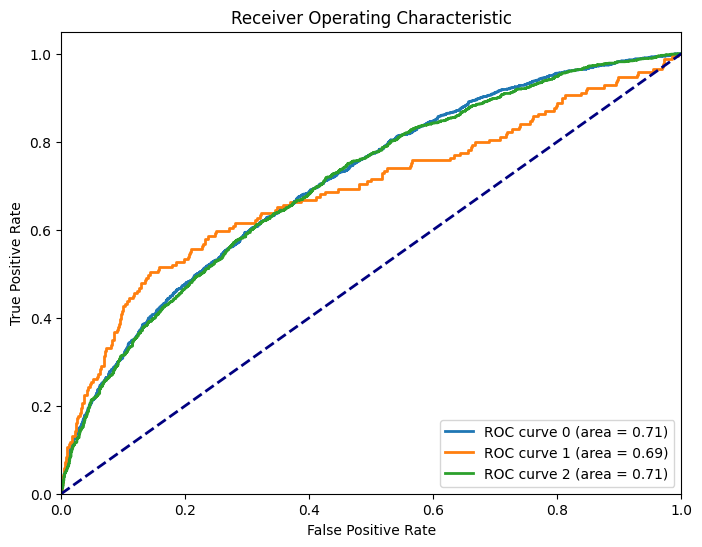

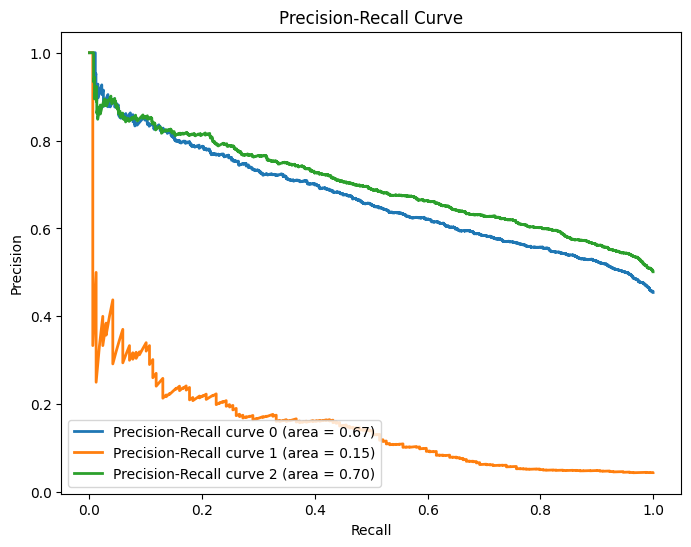

In [162]:
print("Regressio logistica")
fit_model(lr, X_train, y_train, X_test, y_test)

Random Forest
0.6417266187050361
[[1077    0  660]
 [  96    0   73]
 [ 627    0 1290]]
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1737
           1       0.00      0.00      0.00       169
           2       0.64      0.67      0.65      1917

    accuracy                           0.62      3823
   macro avg       0.41      0.43      0.42      3823
weighted avg       0.59      0.62      0.61      3823



c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

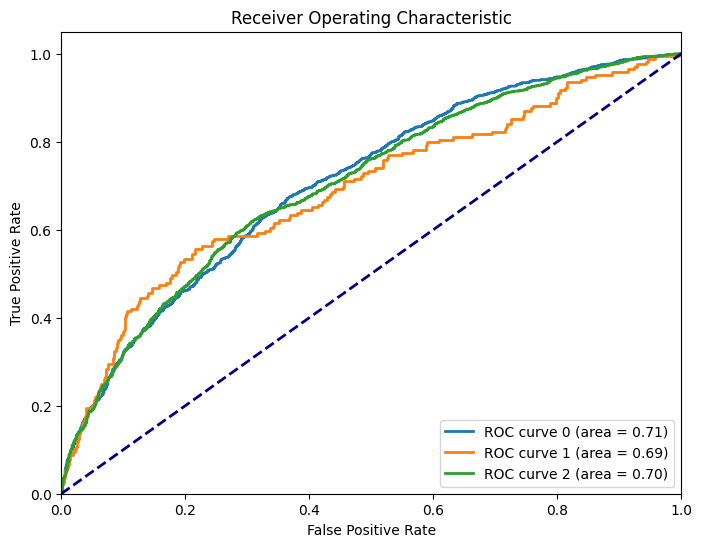

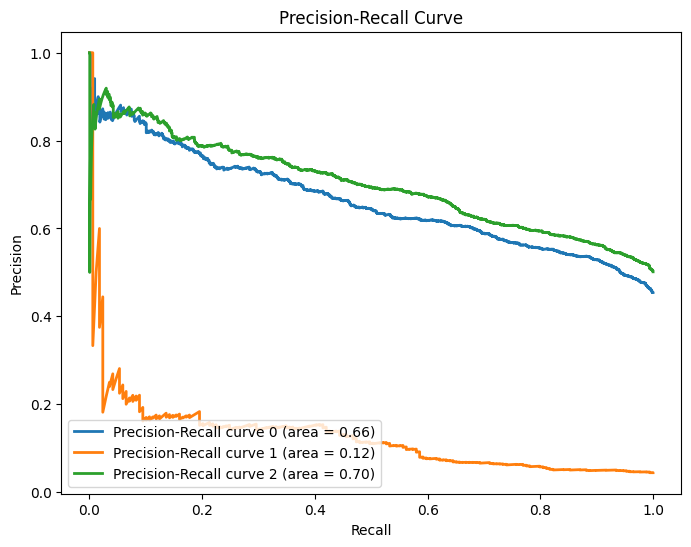

In [163]:
print("Random Forest")
fit_model(rf, X_train, y_train, X_test, y_test)

KNN
0.6080444735120994
[[1010    1  726]
 [  86    0   83]
 [ 626    0 1291]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      1737
           1       0.00      0.00      0.00       169
           2       0.61      0.67      0.64      1917

    accuracy                           0.60      3823
   macro avg       0.40      0.42      0.41      3823
weighted avg       0.57      0.60      0.59      3823



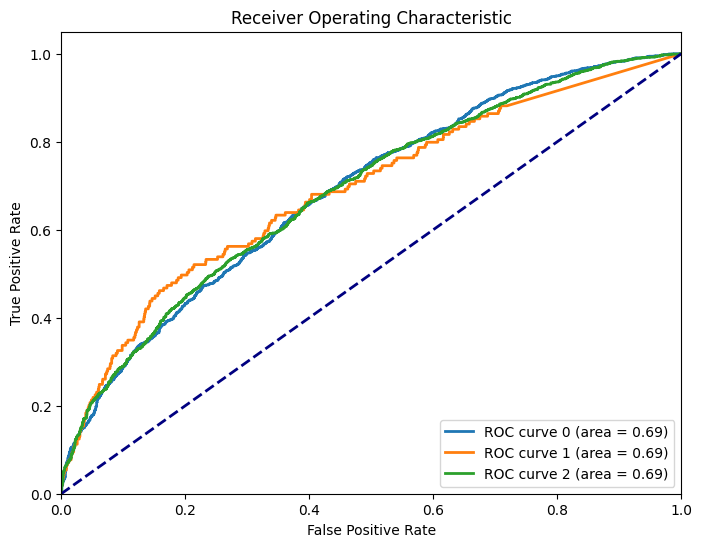

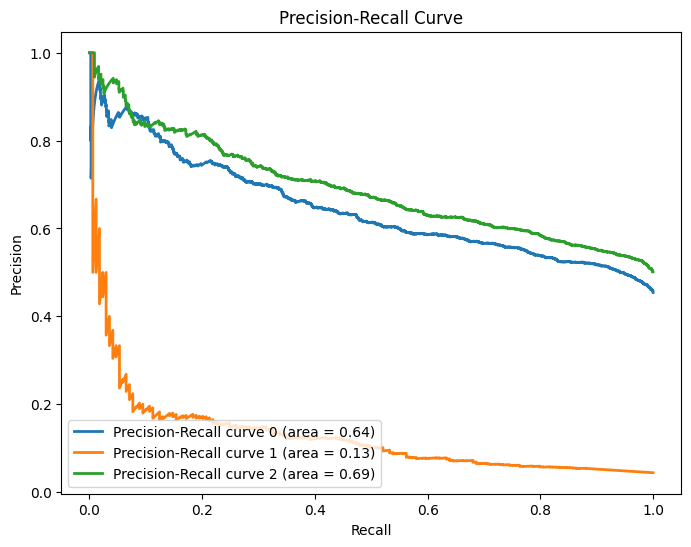

In [164]:
print("KNN")
fit_model(knn, X_train, y_train, X_test, y_test)

SVM
0.6237410071942447
[[1020    0  717]
 [  90    0   79]
 [ 565    0 1352]]
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1737
           1       0.00      0.00      0.00       169
           2       0.63      0.71      0.67      1917

    accuracy                           0.62      3823
   macro avg       0.41      0.43      0.42      3823
weighted avg       0.59      0.62      0.61      3823



c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

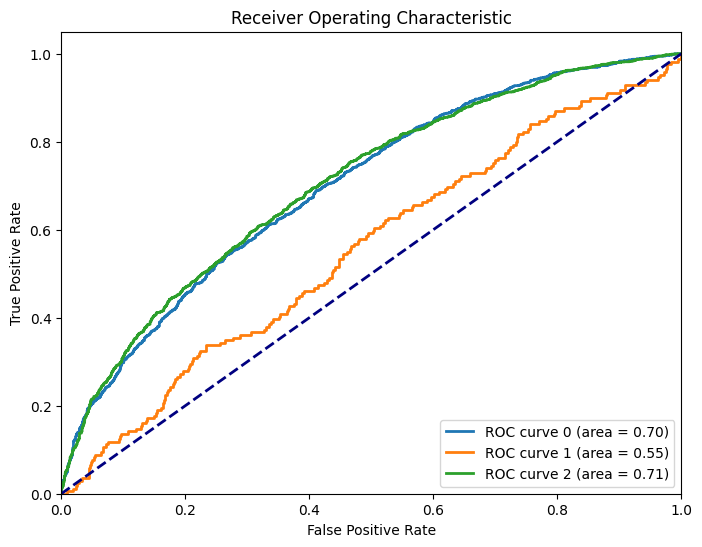

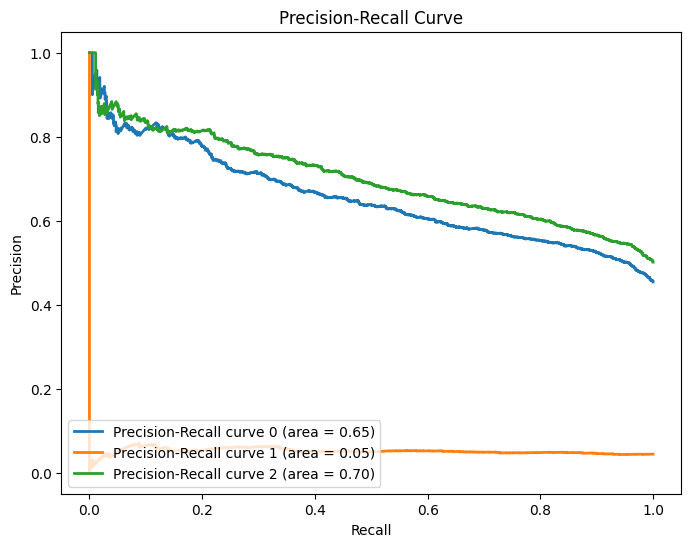

In [165]:
print("SVM")
fit_model(svm, X_train, y_train, X_test, y_test)

## 5.Analisi final
Per l'analisí farem servir el model predictiu regressor logistics, ja que no te resultats molt pitjors al millor (Random Forest), pero sí una eficiencia a nivell de temps molt elevada.

### Analitzem resultat predit
A continuació mostrem un graf amb les prediccions i resultats reals de **winner** en funció de **diff_rating**.

Podem comprobar la ineficiencia del model per classificar empats i en classificar correctament cassos extrems de guanyadors amb poques possibilitats per rating.

In [166]:
lr = LogisticRegression(max_iter=1000, tol=1e-3)

lr.set_params(**lr_param)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

#Mostrem matriu de confusio
print(confusion_matrix(y_test, y_pred))

final_set = test_set.copy()
final_set["predicition"] = y_pred

[[1016    3  718]
 [  86    2   81]
 [ 570    1 1346]]


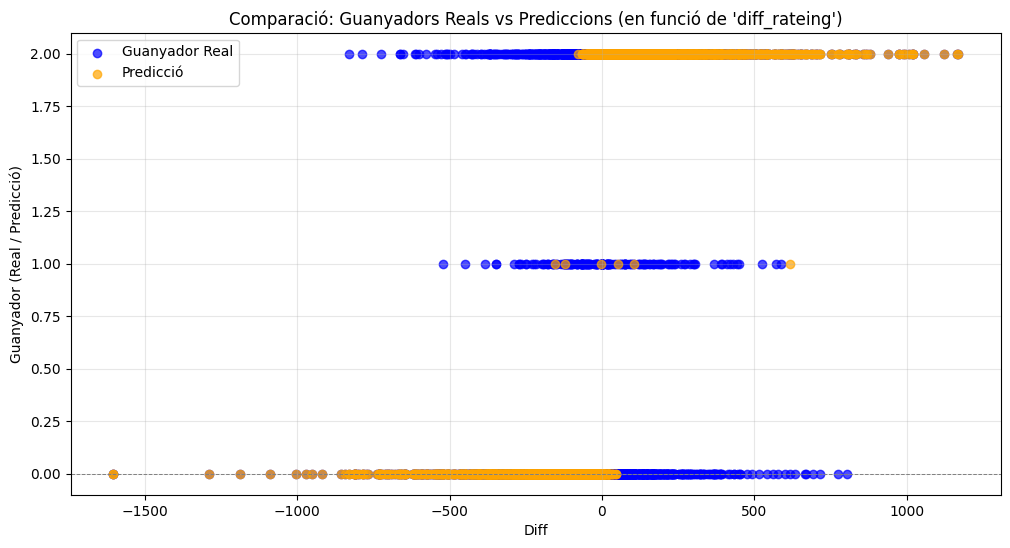

In [167]:
# Dades del zip
true_winner_vs_diff = list(zip(final_set["winner"], final_set["diff_rating"]))
pred_winner_vs_diff = list(zip(final_set["predicition"], final_set["diff_rating"]))

# Dividir les dades en dues llistes per a cada conjunt
true_winners, true_diffs = zip(*true_winner_vs_diff)
pred_winners, pred_diffs = zip(*pred_winner_vs_diff)

# Crear un gràfic de dispersió
plt.figure(figsize=(12, 6))

# Guanyador real vs diff
plt.scatter(true_diffs, true_winners, color='blue', alpha=0.7, label='Guanyador Real')

# Predicció vs diff
plt.scatter(pred_diffs, pred_winners, color='orange', alpha=0.7, label='Predicció')

# Afegir títol i etiquetes
plt.title("Comparació: Guanyadors Reals vs Prediccions (en funció de 'diff_rateing')")
plt.xlabel("Diff")
plt.ylabel("Guanyador (Real / Predicció)")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)  # Línia de referència
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gràfic
plt.show()

### Ideas finals

Hi ha molts factors que no s'han tingut en comptes. Aquesta base de dades li falten dades molt essencials per poder fer millor prediccions, al solament tenir dades com el rating i torns, s'acaban deixant molts factors que podrian haver fet predir millor els resultats. A part d'un problema de recerca, també es pot considerar un problema més fonamental, ja que en un joc com els escacs i ha molts imprevistos i estils de joc que dificilment es poden codificar en una base de dades.